<a href="https://colab.research.google.com/github/MohsenLotfii/School_electricity/blob/main/1_Schools_electricity_Load_Duration_Curves_(Jan_Feb_2023_24)_06_Jan_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Extracted features for year 2023: [[0.01522742925412737, 0.024696460862826144, 1, 1, 1, 0, 0], [0.011342692010542449, 0.03244522093615782, 0, 1, 1, 0, 0], [0.007892313816050722, 0.016977691977691983, 0, 1, 1, 0, 0], [0.01964227306350587, 0.05036123152161832, 0, 1, 0, 1, 0], [0.015691844419203894, 0.030707923112986407, 1, 1, 1, 1, 0], [0.02815106676338121, 0.05144213216502374, 0, 1, 1, 0, 0], [0.02035873187389532, 0.03809107340679844, 0, 0, 0, 1, 0], [0.01612497614214828, 0.03152004164497657, 1, 1, 0, 0, 0], [0.016040026869767198, 0.024103075170842824, 1, 1, 0, 0, 0], [0.00974301232579498, 0.02518916155419223, 1, 0, 0, 0, 0], [0.030561234297373376, 0.071007371007371, 0, 1, 0, 0, 1], [0.013914215791949973, 0.033850931677018636, 0, 0, 0, 0, 0], [0.027769312144259917, 0.057434685936631466, 0, 1, 0, 0, 0], [0.042937023781562896, 0.10183229813664596, 0, 1, 0, 0, 0], [0.006092634677554137, 0.018948995363214836, 1, 1, 0, 0, 0], [0.009334367548239226, 0.026245075260127284, 1, 0, 0, 0, 0], [0.01

<ipython-input-3-f120d9c12706>:598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized'] = normalized_values
<ipython-input-3-f120d9c12706>:598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized'] = normalized_values
<ipython-input-3-f120d9c12706>:598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Generating LDCs for all clusters in year 2023...


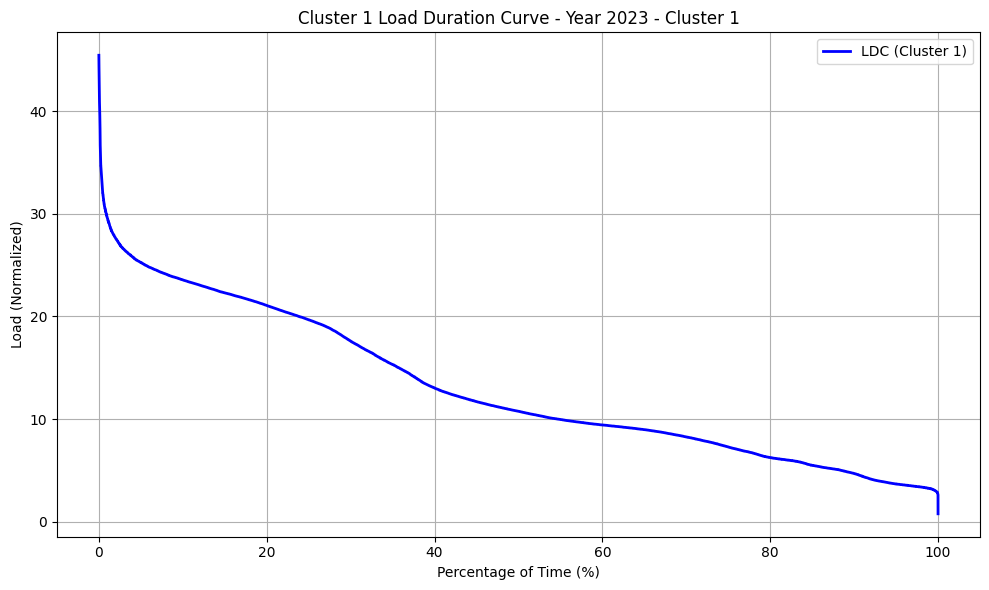

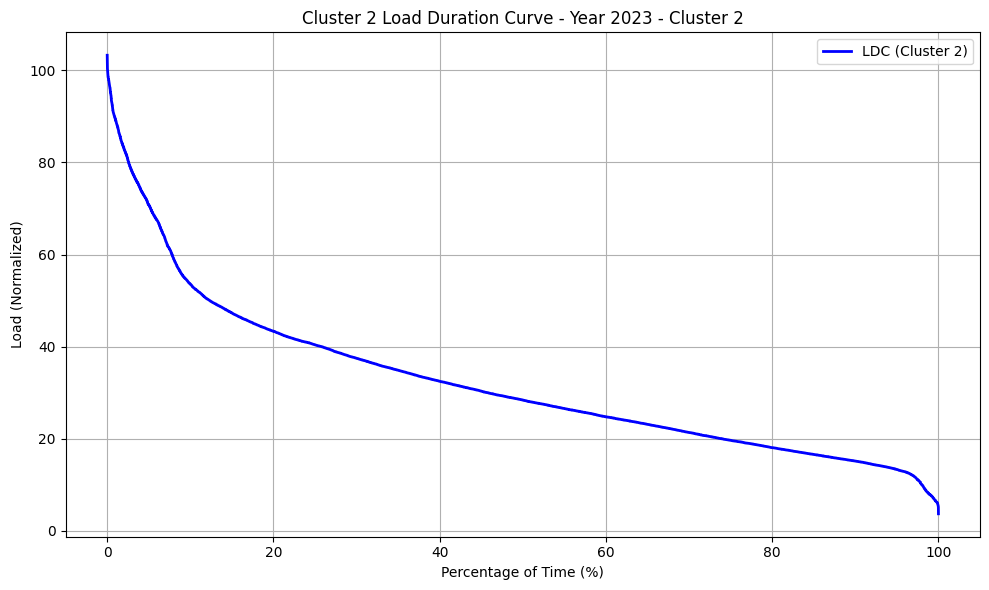

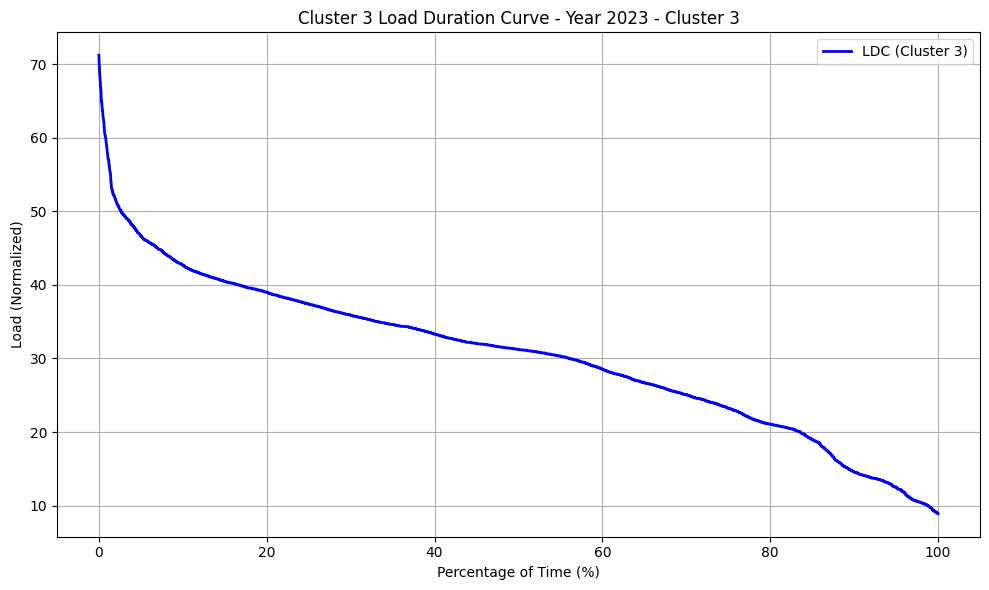

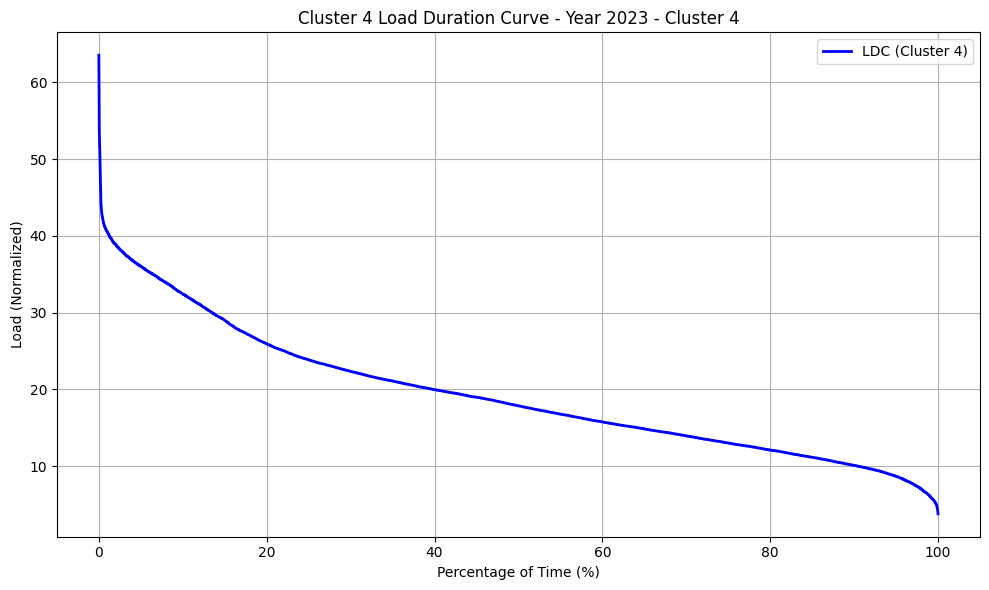

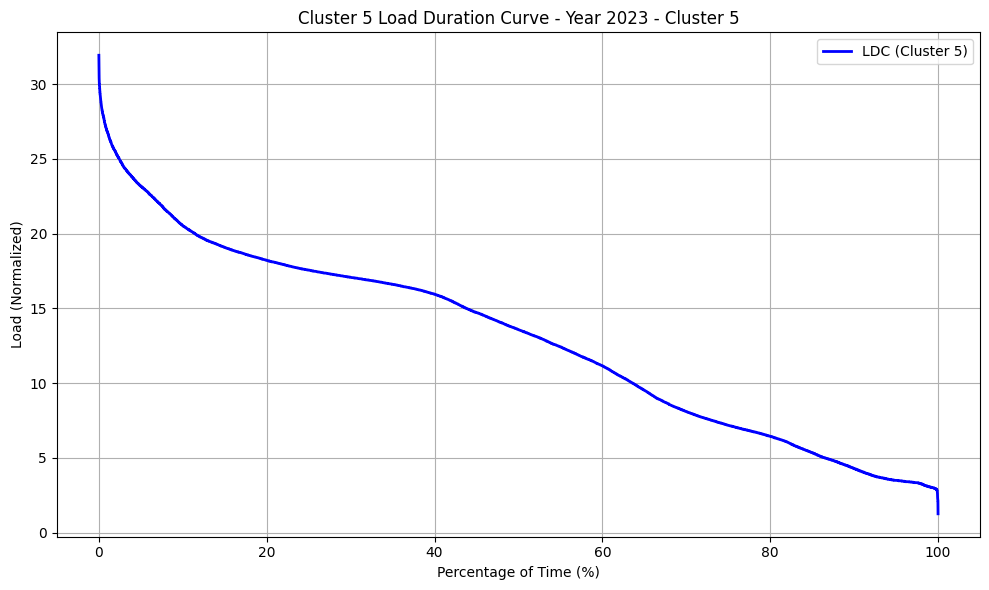

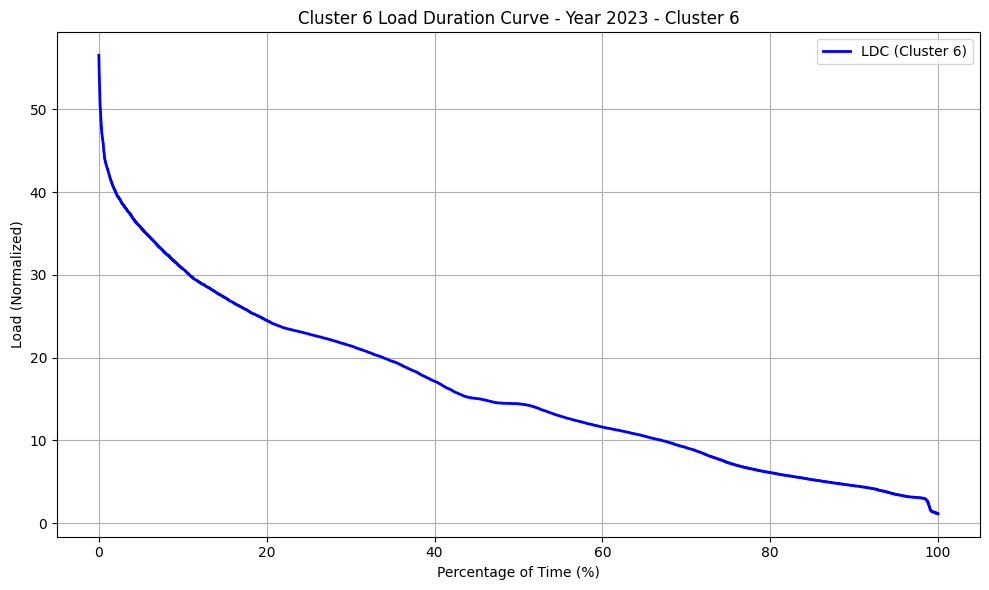

Extracted features for year 2024: [[0.011474642607771373, 0.019720356497029193, 1, 1, 1, 0, 0], [0.011686009856527046, 0.032175875373080004, 0, 1, 1, 0, 0], [0.006698725298006119, 0.015741634491634487, 0, 1, 1, 0, 0], [0.01550088167997422, 0.03538679559853284, 0, 1, 0, 1, 0], [0.01634315605278495, 0.03134418324291742, 1, 1, 1, 1, 0], [0.02660064621928782, 0.04091365461847389, 0, 1, 1, 0, 0], [0.018706059681169323, 0.03890735234097137, 0, 0, 0, 1, 0], [0.014285812193576178, 0.029502863092139512, 1, 1, 0, 0, 0], [0.01268371798411663, 0.023661731207289295, 1, 1, 0, 0, 0], [0.010814890227963763, 0.02418200408997955, 1, 0, 0, 0, 0], [0.030579960506441246, 0.06695331695331695, 0, 1, 0, 0, 1], [0.01333374787260752, 0.030388198757763975, 0, 0, 0, 0, 0], [0.024948115396680782, 0.048540856031128406, 0, 1, 0, 0, 0], [0.03165094842284742, 0.0896583850931677, 0, 1, 0, 0, 0], [0.007124852117715864, 0.01873261205564142, 1, 1, 0, 0, 0], [0.01009754063876063, 0.025936963329629255, 1, 0, 0, 0, 0], [0.01

<ipython-input-3-f120d9c12706>:598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized'] = normalized_values
<ipython-input-3-f120d9c12706>:598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized'] = normalized_values
<ipython-input-3-f120d9c12706>:598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Generating LDCs for all clusters in year 2024...


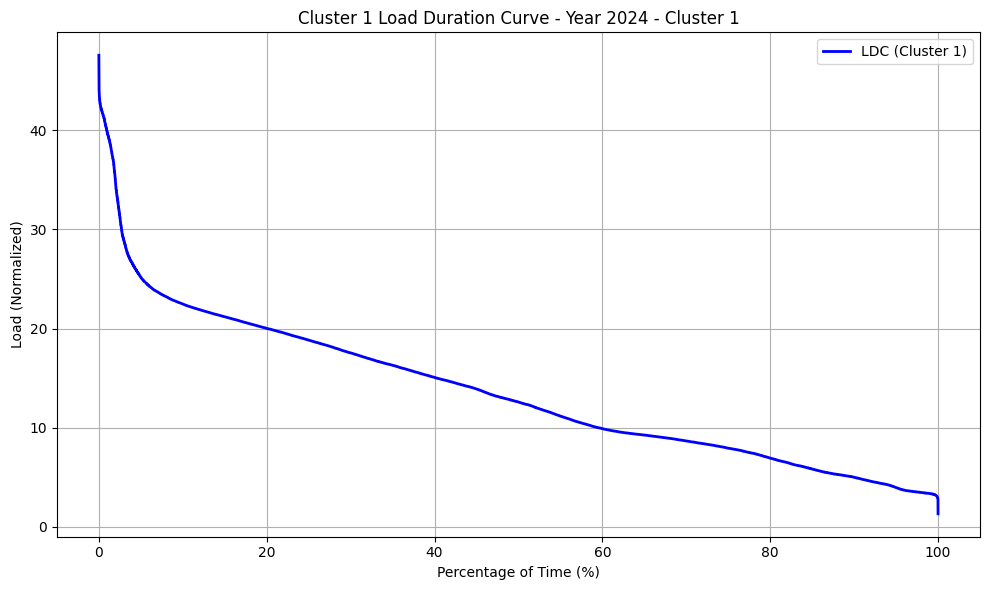

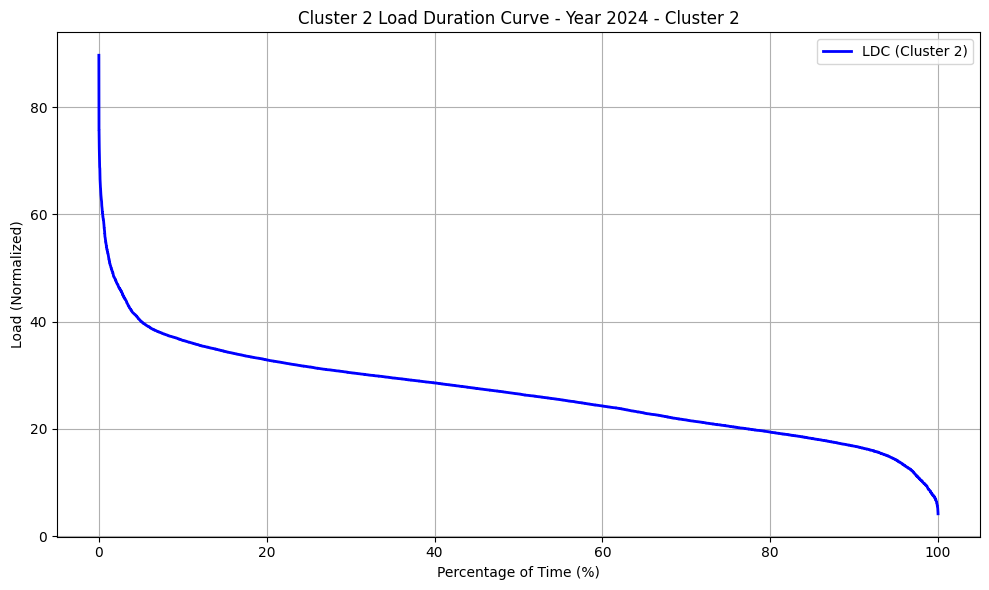

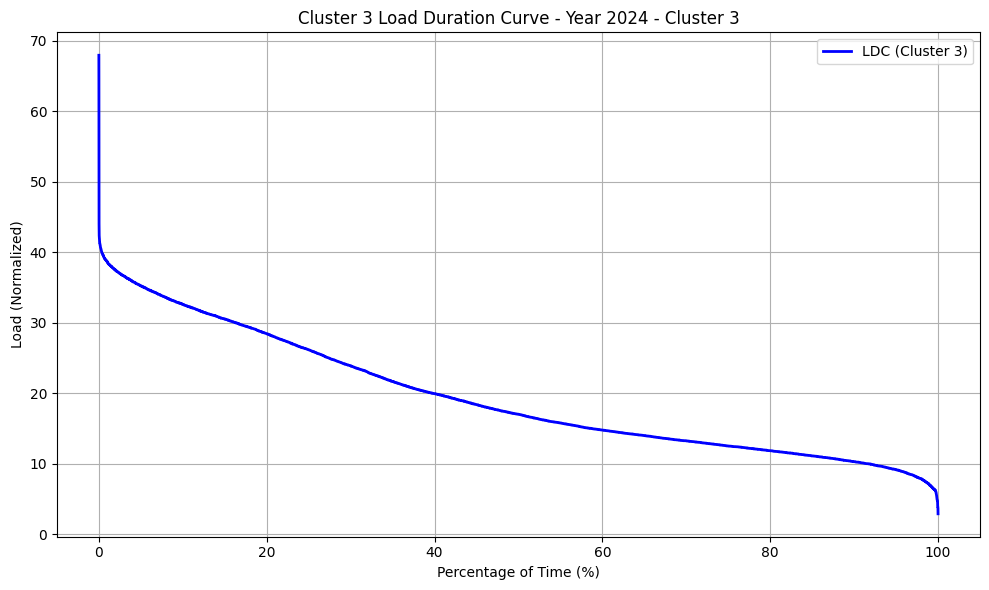

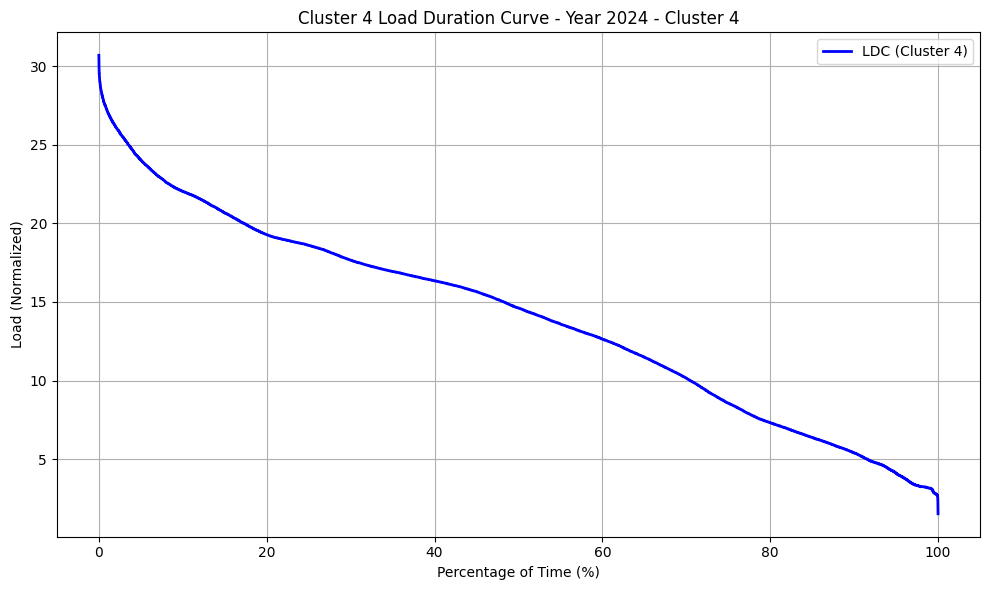

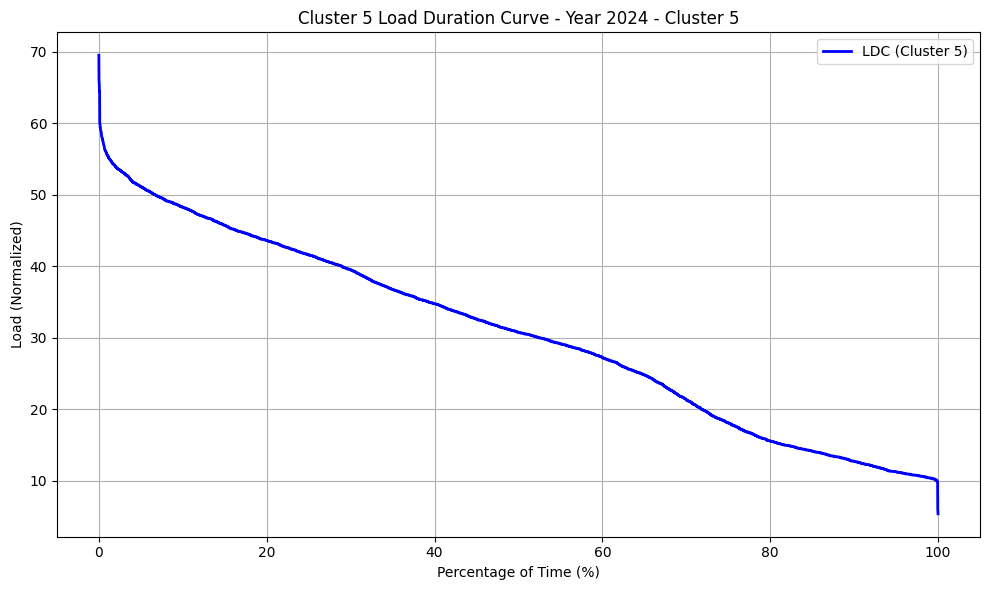

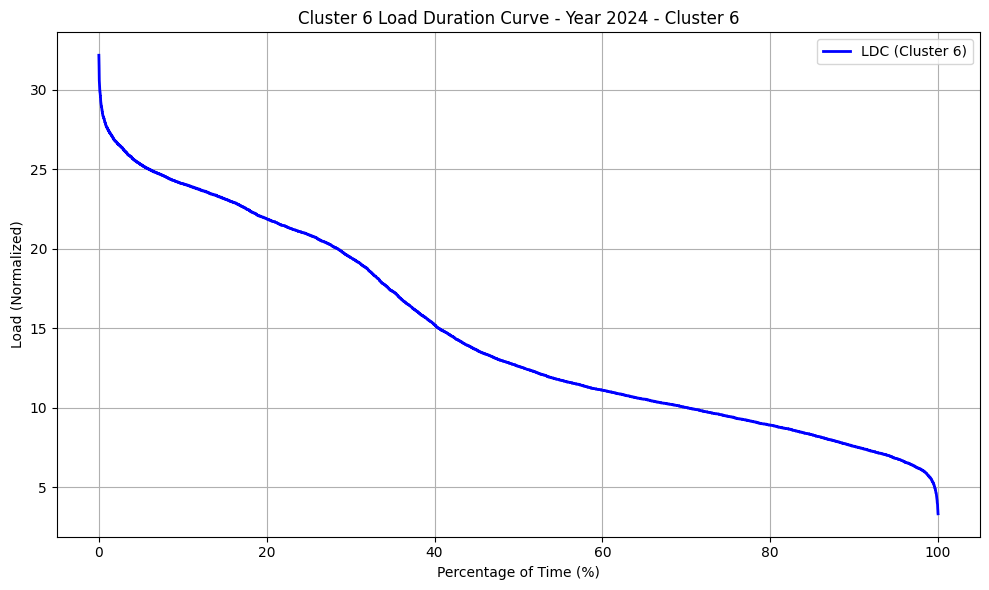

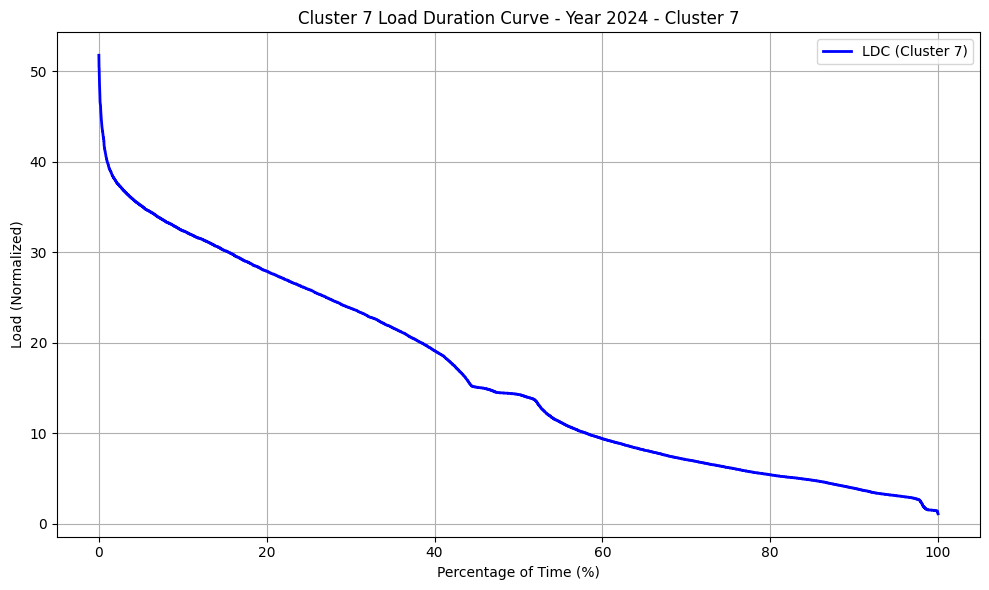

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#############################################################################################################

# Floor areas for each school
floorAreas = {
    "Alpha": 7742,
    "Curé-Paquin": 4579,
    "Des_Perséides,pavillon_des_Primevères": 3108,
    # "Gaston-Pilon(300209825)": 5103,
    # "Gaston-Pilon(300206515)": 5103,
    # "Gaston-Pilon(300205293)": 5103,
    "De_la_Clé-des-Champs": 2999,
    "Horizon-du-Lac": 4977,
    "Marie-Soleil-Tougas": 5478,
    "École_Domaine_Vert-Nord": 5717,
    "Sauvé": 3842,
    # "Village-des-Jeunes (300206655)": 2306,
    # "Village-des-Jeunes (300206667)": 2306,
    #"Terre des jeunes": 3710,
    "Notre-Dame": 3512,
    "Secondaire Rive-Nord": 9780,
    "Sainte-Scholastique": 2442,
    "De la Clairière": 3220,
    "Jeunes du monde": 3598,
    "De l'Aquarelle": 3220,
    "Le Sentier": 3235,
    "Secondaire Lucille-Teasdale": 9899,
    "Saint-Gabriel (pavillon Saint-Gabriel)": 6205,
    "De Fontainebleau": 4275,
    "Arthur-Vaillancourt": 2626,
    "Des Moissons (pavillon Mgr Conrad-Chaumont)": 2957,
    "Secondaire du Harfang (pavillon Saint-François)": 3609,
    "Secondaire d'Oka": 16013,
    "Secondaire Liberté-Jeunesse": 8405,
    "Au Coeur-du-Boisé": 3157,
    "Secondaire Jean-Jacques-Rousseau": 13148,
    "Des Mésanges": 3929,
    "Des Perséides": 4252,
    "Secondaire du Harfang": 8234,
    "De l'Harmonie-Jeunesse": 2825,
    }

# Mechanical equipment details for each school (GB: Gas Boiler, EB: Electric Boiler, TES: Thermal Energy Storage, HP: Heat Pump, GT: Geothermal)
equipment = {
    "Alpha": {"GB": 3, "EB": 1, "TES": 1, "HP": 0, "GT": 0},
    "Curé-Paquin": {"GB": 0, "EB": 1, "TES": 1, "HP": 0, "Radiant Heating": 1, "PV Panel": 1, "GT": 0},
    "Des_Perséides,pavillon_des_Primevères": {"GB": 0, "EB": 2, "TES": 1, "HP": 0, "GT": 0},
    # "Gaston-Pilon(300209825)": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    # "Gaston-Pilon(300206515)": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    # "Gaston-Pilon(300205293)": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    "De_la_Clé-des-Champs": {"GB": 0, "EB": 1, "TES": 0, "HP": 1, "GT": 0},
    "Horizon-du-Lac": {"GB": 1, "EB": 1, "TES": 1, "HP": 36, "GT": 0},
    "Marie-Soleil-Tougas": {"GB": 0, "EB": 2, "TES": 1, "HP": 0, "GSHP":1, "GT": 0, "RF": 1},
    "École_Domaine_Vert-Nord": {"GB": 0, "EB": 0, "TES": 0, "HP": 1, "GT": 0},
    "Sauvé": {"GB": 2, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    # "Village-des-Jeunes (300206655)": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    # "Village-des-Jeunes (300206667)": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    #"Terre des jeunes": {"GB": 2, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "Notre-Dame": {"GB": 1, "EB": 2, "TES": 0, "HP": 0, "GT": 0},
    "Secondaire Rive-Nord": {"GB": 3, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "Sainte-Scholastique": {"GB": 0, "EB": 1, "TES": 0, "HP": 0, "GT": 1},
    "De la Clairière": {"GB": 0, "EB": 0, "OB":1, "TES": 0, "HP": 0, "GT": 0},
    "Jeunes du monde": {"GB": 0, "EB": 2, "TES": 0, "HP": 0, "GT": 0},
    "De l'Aquarelle": {"GB": 0, "EB": 2, "TES": 0, "HP": 0, "GT": 0},
    "Le Sentier": {"GB": 2, "EB": 2, "TES": 0, "HP": 0, "GT": 0},
    "Secondaire Lucille-Teasdale": {"GB": 2, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "Saint-Gabriel (pavillon Saint-Gabriel)": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    "De Fontainebleau": {"GB": 1, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "Arthur-Vaillancourt": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    "Des Moissons (pavillon Mgr Conrad-Chaumont)": {"GB": 1, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    "Secondaire du Harfang (pavillon Saint-François)": {"GB": 2, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "Secondaire d'Oka": {"GB": 2, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    "Secondaire Liberté-Jeunesse": {"GB": 2, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "Au Coeur-du-Boisé": {"GB": 0, "EB": 1, "TES": 0, "HP": 0, "GSHP":1, "GT": 0},
    "Secondaire Jean-Jacques-Rousseau": {"GB": 2, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "Des Mésanges": {"GB": 2, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    "Des Perséides": {"GB": 0, "EB": 1, "TES": 0, "HP": 0, "GT": 0},
    "Secondaire du Harfang": {"GB": 2, "EB": 0, "TES": 0, "HP": 0, "GT": 0},
    "De l'Harmonie-Jeunesse": {"GB": 1, "EB": 0, "TES": 0, "HP": 2, "GT": 0},
}

# Softer, more visually friendly colors for each school
school_colors = {
    "Alpha": "#2E8B57",
    "Curé-Paquin": "#1E90FF",
    "Des_Perséides,pavillon_des_Primevères": "#FF6347",
    # "Gaston-Pilon(300209825)": "#DAA520",
    # "Gaston-Pilon(300206515)": "#8A2BE2",
    # "Gaston-Pilon(300205293)": "#20B2AA",
    "De_la_Clé-des-Champs": "#FF4500",
    "Horizon-du-Lac": "#4682B4",
    "Marie-Soleil-Tougas": "#6A5ACD",
    "École_Domaine_Vert-Nord": "#32CD32",
    "Sauvé": "#00BFFF",
    # "Village-des-Jeunes (300206655)": "#3CB371",
    # "Village-des-Jeunes (300206667)": "#DC143C",
    #"Terre des jeunes": "#DA70D6",
    "Notre-Dame": "#FF8C00",
    "Secondaire Rive-Nord": "#9370DB",
    "Sainte-Scholastique": "#B22222",
    "De la Clairière": "#F4A460",
    "Jeunes du monde": "#BDB76B",
    "De l'Aquarelle": "#483D8B",
    "Le Sentier": "#FF7F50",
    "Secondaire Lucille-Teasdale": "#7B68EE",
    "Saint-Gabriel (pavillon Saint-Gabriel)": "#556B2F",
    "De Fontainebleau": "#CD853F",
    "Arthur-Vaillancourt": "#8B008B",
    "Des Moissons (pavillon Mgr Conrad-Chaumont)": "#BC8F8F",
    "Secondaire du Harfang (pavillon Saint-François)": "#4682B4",
    "Secondaire d'Oka": "#228B22",
    "Secondaire Liberté-Jeunesse": "#CD5C5C",
    "Au Coeur-du-Boisé": "#008B8B",
    "Secondaire Jean-Jacques-Rousseau": "#A0522D",
    "Des Mésanges": "#4169E1",
    "Des Perséides": "#FF69B4",
    "Secondaire du Harfang": "#708090",
    "De l'Harmonie-Jeunesse": "#DAA520",
}

############################################ Load duration curves ##############################################
# Function to generate Load Duration Curves (LDCs)
def generate_load_duration_curve(data, title="Load Duration Curve", year=None, cluster_num=None):
    """
    Generates and plots a Load Duration Curve (LDC) from a dataset of loads.

    Parameters:
    - data: pandas.Series or numpy array of load values.
    - title: str, title of the LDC plot.
    - year: int, optional, the year of the data (for plot annotation).
    - cluster_num: int, optional, the cluster number (for plot annotation).

    Returns:
    None: Displays the plot.
    """
    if len(data) == 0:
        print("No data available for Load Duration Curve.")
        return

    # Sort the load values in descending order
    sorted_data = np.sort(data)[::-1]
    # Generate the percentage of time for the x-axis
    relative_duration = np.linspace(0, 100, len(sorted_data))

    # Plotting the Load Duration Curve
    plt.figure(figsize=(10, 6))
    plt.plot(relative_duration, sorted_data, label=f"LDC (Cluster {cluster_num})", color="blue", linewidth=2)
    plt.title(f"{title} - Year {year} - Cluster {cluster_num}")
    plt.xlabel("Percentage of Time (%)")
    plt.ylabel("Load (Normalized)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to generate LDCs for all clusters without altering original code
def generate_ldcs_for_clusters(year, best_kmeans, labels, school_names, cluster_data_dict):
    """
    Generates Load Duration Curves (LDCs) for all clusters in a given year.

    Parameters:
    - year: int, the year of the data.
    - best_kmeans: sklearn.cluster.KMeans object, the trained KMeans model.
    - labels: array-like, cluster labels for each school.
    - school_names: list of school names corresponding to the data points.
    - cluster_data_dict: dict, pre-collected cluster data where the key is the cluster number,
                         and the value is a pandas.Series or array of 'Normalized' load values.

    Returns:
    None: Displays the LDC plots for all clusters.
    """
    print(f"Generating LDCs for all clusters in year {year}...")

    for cluster in range(best_kmeans.n_clusters):
        # Ensure the cluster data is available
        if cluster in cluster_data_dict and not cluster_data_dict[cluster].empty:
            generate_load_duration_curve(
                cluster_data_dict[cluster],
                title=f"Cluster {cluster + 1} Load Duration Curve",
                year=year,
                cluster_num=cluster + 1,
            )
        else:
            print(f"No data available for Cluster {cluster + 1} in year {year}.")
############################################ Load duration curves ##############################################


############################################# Heat Map #########################################################
def plot_heatmap(normalized_df, year, title="Heat Map - Load Profile", cluster_num=None):
    """
    Generates and plots a heat map (Day of the Year vs. Hour of the Day)
    for normalized load values.

    Parameters:
    - normalized_df: pandas.DataFrame with columns ['Timestamp', 'Normalized'].
    - year: int, the year of the data (for annotation).
    - title: str, title for the heat map.
    - cluster_num: int, optional cluster number for annotation.

    Returns:
    None
    """
    if normalized_df.empty:
        print("Heatmap: The DataFrame is empty. Skipping plot.")
        return

    # Validate required columns
    if 'Timestamp' not in normalized_df.columns or 'Normalized' not in normalized_df.columns:
        print("Heatmap: Missing 'Timestamp' or 'Normalized' column in DataFrame.")
        return

    # Ensure 'Timestamp' is datetime
    try:
        normalized_df['Timestamp'] = pd.to_datetime(normalized_df['Timestamp'], errors='coerce')
    except Exception as e:
        print(f"Heatmap: Error converting 'Timestamp' to datetime - {e}")
        return

    # Drop invalid timestamps
    normalized_df = normalized_df.dropna(subset=['Timestamp'])

    if normalized_df.empty:
        print("Heatmap: All timestamps are invalid after conversion.")
        return

    # Extract day of the year and hour of the day
    normalized_df['Hour'] = normalized_df['Timestamp'].dt.hour
    normalized_df['DayOfYear'] = normalized_df['Timestamp'].dt.dayofyear

    # Debugging: Check unique days and hours
    print(f"Heatmap: Data contains {normalized_df['DayOfYear'].nunique()} days and {normalized_df['Hour'].nunique()} hours.")

    # Create pivot table for heat map
    heatmap_data = normalized_df.pivot_table(
        index='DayOfYear',  # Rows: Day of the year
        columns='Hour',     # Columns: Hour of the day
        values='Normalized',  # Values: Normalized load
        aggfunc='mean'       # Aggregation: Average
    )

    if heatmap_data.empty:
        print("Heatmap: Pivot table is empty. Cannot generate heat map.")
        return

    # Plot heat map
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm',
        cbar_kws={'label': 'Normalized Load (W/m²)'},
        linewidths=0.5
    )
    plt.title(f"{title} - Year {year}{f' - Cluster {cluster_num}' if cluster_num else ''}")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Day of the Year")
    plt.tight_layout()
    plt.show()
############################################# Heat Map #########################################################

# Filter data from the first Monday of January to the last Sunday of February
def filter_january_february(df, year):
    start_date = pd.to_datetime(f'{year}-01-01')
    # Adjust start date to the first Monday of the year if necessary
    if start_date.weekday() != 0:  # Not a Monday
        start_date += pd.DateOffset(days=(7 - start_date.weekday()))
    end_date = pd.to_datetime(f'{year}-02-28')
    # Adjust end date to the last Sunday in February if necessary
    if end_date.weekday() != 6:  # Not a Sunday
        end_date += pd.DateOffset(days=(6 - end_date.weekday()))

    return df[(df.iloc[:, 1] >= start_date) & (df.iloc[:, 1] <= end_date)]

# Extract features based on energy consumption and mechanical equipment presence
def extract_features(year):
    features = []
    school_names = []

    for school_name in floorAreas.keys():
        floor_area = floorAreas[school_name]
        schoolPath = f"/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/{school_name}"

        # Ensure directory exists
        if not os.path.isdir(schoolPath):
            print(f"Warning: Directory {schoolPath} does not exist.")
            continue

        csv_files = [f for f in os.listdir(schoolPath) if f.endswith('.csv')]
        energy_data = []
        for file in csv_files:
            full_path = os.path.join(schoolPath, file)
            try:
                df = pd.read_csv(full_path, delimiter=';', decimal=',')
                df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
                df = df.dropna(subset=[df.columns[1]])

                if df.shape[1] >= 3:
                    df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
                    df = df.dropna(subset=[df.columns[2]])

                    df_filtered = filter_january_february(df, year)
                    if not df_filtered.empty:
                        normalized_values = df_filtered.iloc[:, 2] / floor_area
                        avg_consumption = normalized_values.mean()
                        peak_consumption = normalized_values.max()
                        energy_data.append([avg_consumption, peak_consumption])

            except Exception as e:
                print(f"Error processing file {file} in {schoolPath}: {e}")

        if energy_data:
            avg_energy = np.mean([d[0] for d in energy_data])
            peak_energy = np.mean([d[1] for d in energy_data])

            equip_info = equipment.get(school_name, {})
            equip_features = [1 if equip_info.get(key, 0) > 0 else 0 for key in ["GB", "EB", "TES", "HP", "GT"]]

            features.append([avg_energy, peak_energy] + equip_features)
            school_names.append(school_name)

    print(f"Extracted features for year {year}: {features}")  # Debug line to verify feature extraction
    return np.array(features), school_names

# Perform K-Means clustering with silhouette score optimization
def optimized_kmeans(features, n_clusters_range=(2, 10)):
    best_score = -1
    best_kmeans = None
    best_labels = None
    silhouette_scores = []  # Initialize a list to store silhouette scores

    for n_clusters in range(n_clusters_range[0], min(n_clusters_range[1], len(features))):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels = kmeans.fit_predict(features)
        score = silhouette_score(features, labels)
        silhouette_scores.append((n_clusters, score))  # Append score to the list
        if score > best_score:
            best_score, best_kmeans, best_labels = score, kmeans, labels
    return best_kmeans, best_labels, silhouette_scores  # Return silhouette scores

# Interpret the cluster's mechanical equipment based on centroid values
def interpret_cluster_equipment(centroid):
    equipment_types = ["GB", "EB", "TES", "HP", "GT"]
    interpretation = ', '.join([equipment_types[i] for i, val in enumerate(centroid[2:]) if val >= 0.5])
    print(f"Cluster equipment interpretation: {interpretation}")  # Debug line
    return interpretation

#############################################################################################################

# Function to generate all weekday and weekend timestamps at 8 AM in January and February
def generate_jan_feb_timestamps(year):
    jan_feb_weekdays = []
    jan_feb_weekends = []
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 2, 28)

    current_date = start_date
    while current_date <= end_date:
        time_at_8am = current_date.replace(hour=8, minute=0, second=0)
        if current_date.weekday() < 5:  # Monday=0, Friday=4 (weekdays)
            jan_feb_weekdays.append(time_at_8am)
        else:  # Saturday=5, Sunday=6 (weekends)
            jan_feb_weekends.append(time_at_8am)
        current_date += timedelta(days=1)
    return jan_feb_weekdays, jan_feb_weekends

# Complete cluster_and_plot function with peak load detection at 8 AM for weekdays and weekends in January and February
def cluster_and_plot(year):
    features, school_names = extract_features(year)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    best_kmeans, labels, silhouette_scores = optimized_kmeans(features_scaled)

    # Plot Silhouette scores
    plt.figure(figsize=(10, 6))
    n_clusters, scores = zip(*silhouette_scores)
    plt.plot(n_clusters, scores, marker='o', linestyle='-', color='b')
    plt.title(f'Silhouette Scores for Different Numbers of Clusters - Year {year}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    centroids = scaler.inverse_transform(best_kmeans.cluster_centers_)


    # Generate timestamps for all weekdays and weekends at 8 AM in January and February
    specific_weekday_times, specific_weekend_times = generate_jan_feb_timestamps(year)

    print(f"Total clusters for {year}: {best_kmeans.n_clusters}")  # Debug line

    # Dictionaries to store peak loads for each cluster for combined plotting
    cluster_weekday_peak_loads = {}
    cluster_weekend_peak_loads = {}

    for cluster in range(best_kmeans.n_clusters):
        plt.figure(figsize=(10, 6))
        cluster_schools = [school_names[i] for i, label in enumerate(labels) if label == cluster]

        print(f"Cluster {cluster + 1} for {year} contains schools: {cluster_schools}")  # Debug line

        legend_added = set()
        all_schools_data = []  # Collect data to calculate the average for the cluster
        cluster_data = pd.DataFrame()  # For typical week calculation

        # Lists to collect peak loads at 8 AM on specified weekdays and weekends in Jan-Feb for this cluster
        weekday_peak_loads_for_distribution = []
        weekend_peak_loads_for_distribution = []

        for school_name in cluster_schools:
            schoolPath = f"/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/{school_name}"
            floor_area = floorAreas[school_name]
            color = school_colors.get(school_name, 'black')
            csv_files = [f for f in os.listdir(schoolPath) if f.endswith('.csv')]

            # Get equipment types for the school
            equipment_types = equipment.get(school_name, {})
            equipment_str = ", ".join([key for key, count in equipment_types.items() if count > 0])
            legend_label = f"{school_name}: {equipment_str}"

            school_data = pd.DataFrame()
            for file in csv_files:
                full_path = os.path.join(schoolPath, file)
                try:
                    df = pd.read_csv(full_path, delimiter=';', decimal=',')
                    df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
                    df = df.dropna(subset=[df.columns[1]])

                    if df.shape[1] >= 3:
                        df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
                        df = df.dropna(subset=[df.columns[2]])

                        df_filtered = filter_january_february(df, year)
                        if not df_filtered.empty:
                            # Normalize data and add to school data
                            normalized_values = (df_filtered.iloc[:, 2] / floor_area) * 1000
                            df_filtered['Normalized'] = normalized_values
                            school_data = pd.concat([school_data, df_filtered[['Normalized', df.columns[1]]]])
                            label = legend_label if school_name not in legend_added else None
                            plt.plot(df_filtered.iloc[:, 1], normalized_values, label=label, color=color)
                            legend_added.add(school_name)

                            # Collect peak loads at 8 AM on specified weekdays and weekends in January-February
                            for peak_time in specific_weekday_times:
                                peak_value = df_filtered[df_filtered[df.columns[1]] == peak_time]
                                if not peak_value.empty:
                                    weekday_peak_loads_for_distribution.append(peak_value['Normalized'].values[0])
                            for peak_time in specific_weekend_times:
                                peak_value = df_filtered[df_filtered[df.columns[1]] == peak_time]
                                if not peak_value.empty:
                                    weekend_peak_loads_for_distribution.append(peak_value['Normalized'].values[0])

                except Exception as e:
                    print(f"Error processing file {file} in {schoolPath}: {e}")

            # Collect data for cluster average and typical week
            if not school_data.empty:
                school_data.set_index(df.columns[1], inplace=True)
                school_data = school_data.resample('15T').mean()  # Resample to 15-minute intervals
                all_schools_data.append(school_data['Normalized'])
                cluster_data = pd.concat([cluster_data, school_data['Normalized']])

        # Plot average load profile for the cluster
        if all_schools_data:
            cluster_avg = pd.concat(all_schools_data, axis=1).mean(axis=1)
            plt.plot(cluster_avg.index, cluster_avg, label="Cluster Average", color="black", linestyle="--", linewidth=2)

        plt.title(f'Cluster {cluster + 1} - {year}')
        plt.xlabel('Date')
        plt.ylabel('W/m²')
        plt.legend(title="Schools")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Store peak loads for combined plots
        if weekday_peak_loads_for_distribution:
            cluster_weekday_peak_loads[cluster + 1] = weekday_peak_loads_for_distribution
        if weekend_peak_loads_for_distribution:
            cluster_weekend_peak_loads[cluster + 1] = weekend_peak_loads_for_distribution

        # Individual "statistical distribution of peak load" for each cluster on weekdays
        if weekday_peak_loads_for_distribution:
            plt.figure(figsize=(10, 6))
            counts, bins, _ = plt.hist(weekday_peak_loads_for_distribution, bins=15, color="skyblue", edgecolor="black", alpha=0.7, density=True)

            # Gaussian Fit
            mu, sigma = np.mean(weekday_peak_loads_for_distribution), np.std(weekday_peak_loads_for_distribution)
            x = np.linspace(min(weekday_peak_loads_for_distribution), max(weekday_peak_loads_for_distribution), 100)
            plt.plot(x, norm.pdf(x, mu, sigma), color="red", linestyle="--", linewidth=2, label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}')

            plt.title(f'Statistical Distribution of Peak Load at 8 AM on Jan-Feb Weekdays - Cluster {cluster + 1} - {year}')
            plt.xlabel("Normalized Peak Load (W/m²)")
            plt.ylabel("Density")
            plt.legend()
            plt.grid(True)
            plt.show()

        # Individual "statistical distribution of peak load" for each cluster on weekends
        if weekend_peak_loads_for_distribution:
            plt.figure(figsize=(10, 6))
            counts, bins, _ = plt.hist(weekend_peak_loads_for_distribution, bins=15, color="lightcoral", edgecolor="black", alpha=0.7, density=True)

            # Gaussian Fit
            mu, sigma = np.mean(weekend_peak_loads_for_distribution), np.std(weekend_peak_loads_for_distribution)
            x = np.linspace(min(weekend_peak_loads_for_distribution), max(weekend_peak_loads_for_distribution), 100)
            plt.plot(x, norm.pdf(x, mu, sigma), color="blue", linestyle="--", linewidth=2, label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}')

            plt.title(f'Statistical Distribution of Peak Load at 8 AM on Jan-Feb Weekends - Cluster {cluster + 1} - {year}')
            plt.xlabel("Normalized Peak Load (W/m²)")
            plt.ylabel("Density")
            plt.legend()
            plt.grid(True)
            plt.show()

        # Typical week and day plots remain unchanged as in your original requirements...

    # Combined "statistical distribution of peak load" for all clusters on weekdays
    if cluster_weekday_peak_loads:
        plt.figure(figsize=(12, 8))
        colors = plt.cm.tab10.colors
        for i, (cluster_num, peak_loads) in enumerate(cluster_weekday_peak_loads.items()):
            counts, bins, _ = plt.hist(peak_loads, bins=15, color=colors[i % len(colors)], edgecolor="black", alpha=0.5, density=True, label=f'Cluster {cluster_num}')

            # Gaussian Fit for each cluster
            mu, sigma = np.mean(peak_loads), np.std(peak_loads)
            x = np.linspace(min(peak_loads), max(peak_loads), 100)
            plt.plot(x, norm.pdf(x, mu, sigma), color=colors[i % len(colors)], linestyle="--", linewidth=2, label=f'Cluster {cluster_num} Fit\nμ={mu:.2f}, σ={sigma:.2f}')

        plt.title(f'Combined Statistical Distribution of Peak Load at 8 AM on Jan-Feb Weekdays - Year {year}')
        plt.xlabel("Normalized Peak Load (W/m²)")
        plt.ylabel("Density")
        plt.legend(title="Clusters")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Combined "statistical distribution of peak load" for all clusters on weekends
    if cluster_weekend_peak_loads:
        plt.figure(figsize=(12, 8))
        for i, (cluster_num, peak_loads) in enumerate(cluster_weekend_peak_loads.items()):
            counts, bins, _ = plt.hist(peak_loads, bins=15, color=colors[i % len(colors)], edgecolor="black", alpha=0.5, density=True, label=f'Cluster {cluster_num}')

            # Gaussian Fit for each cluster
            mu, sigma = np.mean(peak_loads), np.std(peak_loads)
            x = np.linspace(min(peak_loads), max(peak_loads), 100)
            plt.plot(x, norm.pdf(x, mu, sigma), color=colors[i % len(colors)], linestyle="--", linewidth=2, label=f'Cluster {cluster_num} Fit\nμ={mu:.2f}, σ={sigma:.2f}')

        plt.title(f'Combined Statistical Distribution of Peak Load at 8 AM on Jan-Feb Weekends - Year {year}')
        plt.xlabel("Normalized Peak Load (W/m²)")
        plt.ylabel("Density")
        plt.legend(title="Clusters")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

############################################ Load duration curves ##############################################
# Modified cluster_and_plot to Collect Cluster Data
def cluster_and_plot(year):
    features, school_names = extract_features(year)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    best_kmeans, labels, silhouette_scores = optimized_kmeans(features_scaled)

    cluster_data_dict = {}  # Collect cluster data for LDCs

    for cluster in range(best_kmeans.n_clusters):
        cluster_data = pd.DataFrame()

        for school_name in [school_names[i] for i, label in enumerate(labels) if label == cluster]:
            schoolPath = f"/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/{school_name}"
            floor_area = floorAreas[school_name]
            csv_files = [f for f in os.listdir(schoolPath) if f.endswith('.csv')]

            for file in csv_files:
                full_path = os.path.join(schoolPath, file)
                try:
                    df = pd.read_csv(full_path, delimiter=';', decimal=',')
                    df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
                    df = df.dropna(subset=[df.columns[1]])

                    if df.shape[1] >= 3:
                        df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
                        df = df.dropna(subset=[df.columns[2]])

                        df_filtered = filter_january_february(df, year)
                        if not df_filtered.empty:
                            normalized_values = (df_filtered.iloc[:, 2] / floor_area) * 1000
                            df_filtered['Normalized'] = normalized_values
                            cluster_data = pd.concat([cluster_data, df_filtered[['Normalized', df.columns[1]]]])

                except Exception as e:
                    print(f"Error processing file {file} in {schoolPath}: {e}")

        if not cluster_data.empty:
            cluster_data_dict[cluster] = cluster_data['Normalized']

    # Generate LDCs for clusters
    generate_ldcs_for_clusters(year, best_kmeans, labels, school_names, cluster_data_dict)
############################################ Load duration curves ##############################################


############################################# Heat Map #########################################################
############################################# Heat Map #########################################################


# Run for both years
cluster_and_plot(2023)
cluster_and_plot(2024)






# New Section